In [6]:
#install.packages("data.table")
install.packages("gridExtra")
install.packages("ggExtra")

Installing package into 'C:/Users/NAVEP/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
Warning message:
"package 'gridExtra' is in use and will not be installed"Installing package into 'C:/Users/NAVEP/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
also installing the dependencies 'yaml', 'htmlwidgets', 'httpuv', 'xtable', 'sourcetools', 'later', 'promises', 'colourpicker', 'miniUI', 'shiny', 'shinyjs'




  There is a binary version available but the source version is later:
      binary source needs_compilation
later  0.7.5  0.8.0              TRUE

  Binaries will be installed
package 'yaml' successfully unpacked and MD5 sums checked
package 'htmlwidgets' successfully unpacked and MD5 sums checked
package 'httpuv' successfully unpacked and MD5 sums checked
package 'xtable' successfully unpacked and MD5 sums checked
package 'sourcetools' successfully unpacked and MD5 sums checked
package 'later' successfully unpacked and MD5 sums checked
package 'promises' successfully unpacked and MD5 sums checked
package 'colourpicker' successfully unpacked and MD5 sums checked
package 'miniUI' successfully unpacked and MD5 sums checked
package 'shiny' successfully unpacked and MD5 sums checked
package 'shinyjs' successfully unpacked and MD5 sums checked
package 'ggExtra' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\NAVEP\AppData\Local\Temp\Rtmp6hG10b\d

In [1]:

library(data.table)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(ggExtra)

Warning message:
"package 'data.table' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'ggExtra' was built under R version 3.5.2"

In [50]:
seasons <- fread('Seasons.csv')
seeds <- fread('NCAATourneySeeds.csv')
teams <- fread('Teams.csv')
seas_results <- fread('RegularSeasonCompactResults.csv')
tour_results <- fread('NCAATourneyCompactResults.csv')
seas_detail <- fread('RegularSeasonDetailedResults.csv')
tour_detail <- fread('NCAATourneyDetailedResults.csv')
conferences <- fread('Conferences.csv')
team_conferences <- fread('TeamConferences.csv')
coaches <- fread('TeamCoaches.csv')
distance <- fread('TourneyGeog.csv')

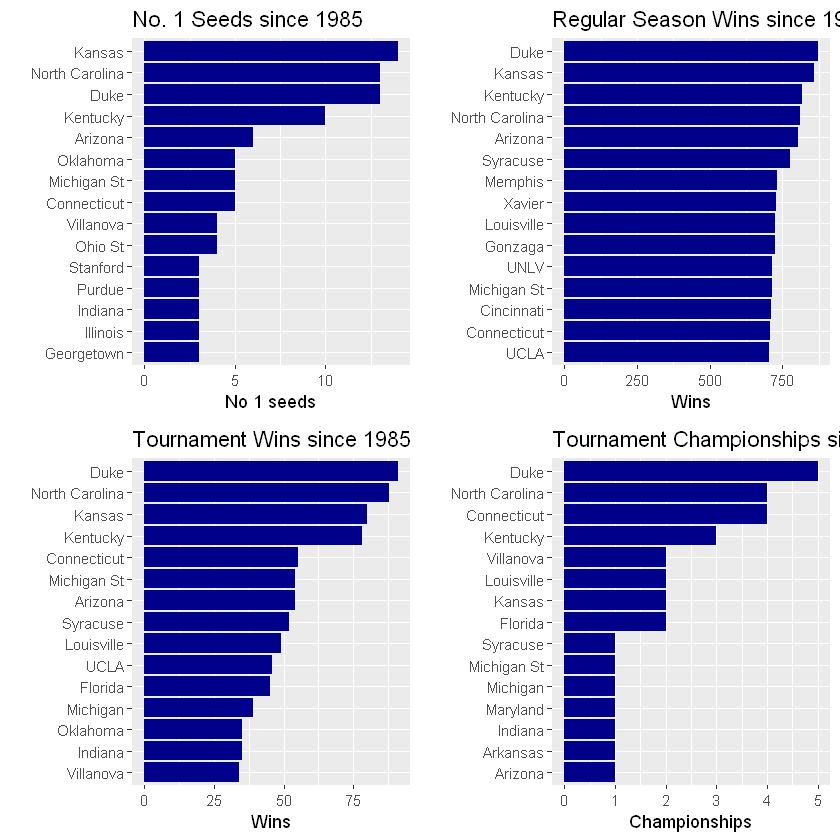

In [12]:
setkey(teams, TeamID)
setkey(seeds, TeamID)

g1 <-
    teams[seeds][, one_seed := as.numeric(substr(Seed, 2, 3)) == 1][, sum(one_seed), by = TeamName][order(V1, decreasing = T)][1:15,] %>%
    ggplot(aes(x = reorder(TeamName, V1), y = V1)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    labs(x = '', y = 'No 1 seeds', title = 'No. 1 Seeds since 1985') +
    coord_flip()

setkey(seas_results, WTeamID)

g2 <-
    seas_results[teams][, .(wins = .N), by = TeamName][order(-wins)][1:15,] %>%
    ggplot(aes(x = reorder(TeamName, wins), y = wins)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    labs(x = '', y = 'Wins', title = 'Regular Season Wins since 1985') +
    coord_flip()

setkey(tour_results, WTeamID)

g3 <-
    tour_results[teams][, .(wins = .N), by = TeamName][order(-wins)][1:15,] %>%
    ggplot(aes(x = reorder(TeamName, wins), y = wins)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    labs(x = '', y = 'Wins', title = 'Tournament Wins since 1985') +
    coord_flip()

g4 <-
    tour_results[teams][DayNum == 154, .(wins = .N), by = TeamName][order(-wins)][1:15,] %>%
    ggplot(aes(x = reorder(TeamName, wins), y = wins)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    labs(x = '', y = 'Championships', title = 'Tournament Championships since 1985') +
    coord_flip()

grid.arrange(g1, g2, g3, g4, nrow = 2)

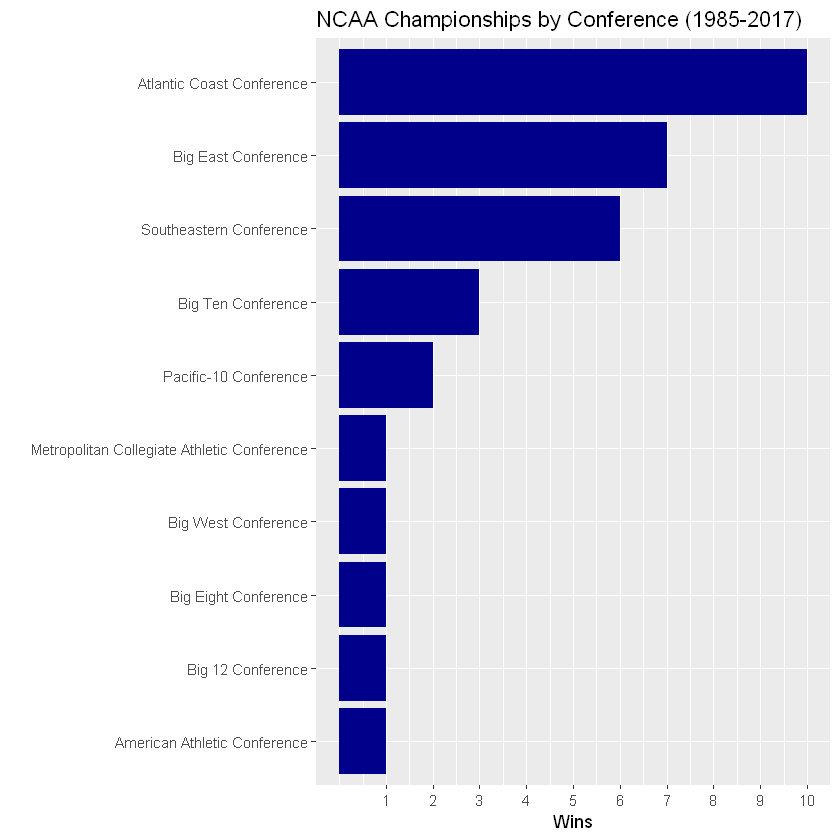

In [13]:
tour_results[team_conferences, on = c(WTeamID = 'TeamID', 'Season'), nomatch = 0
             ][DayNum == 154, .(ConfAbbrev, wins = .N), by = ConfAbbrev
               ][conferences, on = 'ConfAbbrev', nomatch = 0] %>%
    ggplot(aes(x = reorder(Description, wins), y = wins)) + 
    geom_bar(
        stat = 'identity', 
        fill = 'darkblue') + 
    labs(
        x = '', 
        y = 'Wins', 
        title = 'NCAA Championships by Conference (1985-2017)') + 
    scale_y_continuous(breaks = c(1:10)) + 
    coord_flip()

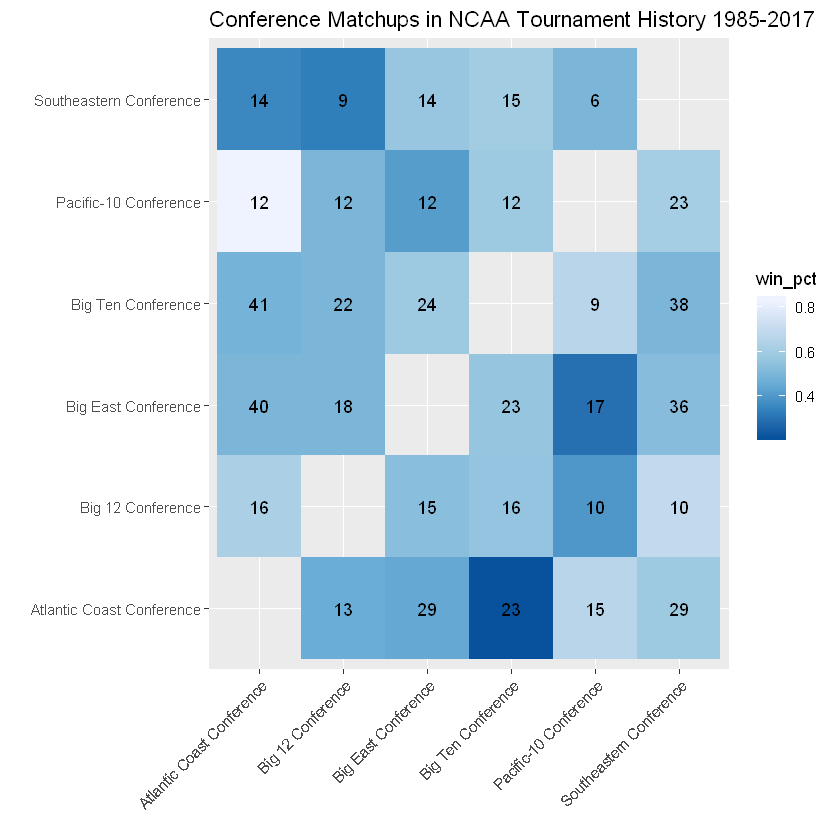

In [14]:
top_conf <- c('acc', 'big_east', 'sec', 'big_ten', 'pac_ten', 'big_twelve')

tour_results[, .(Season,
                 TeamID1 = pmin(WTeamID, LTeamID), 
                 TeamID2 = pmax(WTeamID, LTeamID),
                 low_team_win = ifelse(WTeamID == pmin(WTeamID, LTeamID), 1, 0))
             ][team_conferences, on = c(TeamID1 = 'TeamID', 'Season'), nomatch = 0
               ][team_conferences, on = c(TeamID2 = 'TeamID', 'Season'), nomatch = 0
                 ][ConfAbbrev %in% top_conf & i.ConfAbbrev %in% top_conf
                   ][, .(win_pct = sum(low_team_win) / .N, n = .N), by = c('ConfAbbrev', 'i.ConfAbbrev')
                   ][conferences, on = 'ConfAbbrev',  nomatch = 0
                     ][conferences, on = c(i.ConfAbbrev = 'ConfAbbrev'), nomatch = 0
                       ][ConfAbbrev != i.ConfAbbrev] %>%
    ggplot(aes(x = Description, y = i.Description, fill = win_pct)) + 
    geom_tile() + 
    geom_text(aes(label = n)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    labs(x = '', y = '', title = 'Conference Matchups in NCAA Tournament History 1985-2017') + 
    scale_fill_distiller(palette = "Blues")

In [34]:
win_stats <- seas_detail[, .(
    Season,
    TeamID = WTeamID,
    Outcome = rep('W', .N),
    FGM = WFGM,
    FGA = WFGA,
    FGP = WFGM / WFGA,
    FGP2 = (WFGM - WFGM3) / (WFGA - WFGA3),
    FGM3 = WFGM3,
    FGA3 = WFGA3,
    FGP3 = WFGM3 / WFGA3,
    FTM = WFTM,
    FTA = WFTA,
    FTP = WFTM / WFTA,
    OR = WOR,
    DR = WDR,
    AST = WAst,
    TO = WTO,
    STL = WStl,
    BLK = WBlk,
    PF = WPF,
    ORP = WOR / (WOR + LDR),
    DRP = WDR / (WDR + LOR),
    POS = 0.96 * (WFGA + WTO + 0.44 * WFTA - WOR)
    )]

los_stats <- seas_detail[, .(
    Season,
    TeamID = LTeamID,
    Outcome = rep('L', .N),
    FGM = LFGM,
    FGA = LFGA,
    FGP = LFGM / LFGA,
    FGP2 = (LFGM - LFGM3) / (LFGA - LFGA3),
    FGM3 = LFGM3,
    FGA3 = LFGA3,
    FGP3 = LFGM3 / LFGA3,
    FTM = LFTM,
    FTA = LFTA,
    FTP = LFTM / LFTA,
    OR = LOR,
    DR = LDR,
    AST = LAst,
    TO = LTO,
    STL = LStl,
    BLK = LBlk,
    PF = LPF,
    ORP = (LOR / (LOR + WDR)),
    DRP = LDR / (LDR + WOR),
    POS = 0.96 * (LFGA + LTO + 0.44 * LFTA - LOR)
    )]

stats_all <- rbindlist(list(win_stats, los_stats))

Warning message:
"Removed 36 rows containing non-finite values (stat_density)."

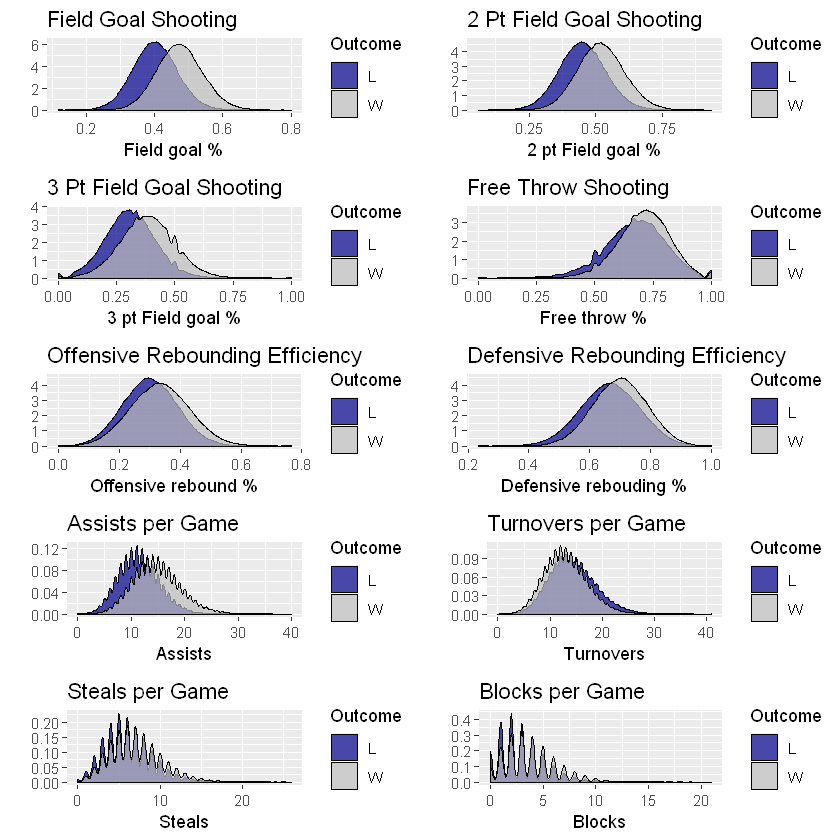

In [17]:
g1 <- stats_all %>%
    ggplot(aes(x = FGP, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Field goal %', y = '', title = 'Field Goal Shooting')

g2 <- stats_all %>%
    ggplot(aes(x = FGP2, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = '2 pt Field goal %', y = '', title = '2 Pt Field Goal Shooting')

g3 <- stats_all %>%
    ggplot(aes(x = FGP3, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = '3 pt Field goal %', y = '', title = '3 Pt Field Goal Shooting')

g4 <- stats_all %>%
    ggplot(aes(x = FTP, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Free throw %', y = '', title = 'Free Throw Shooting')

g5 <- stats_all %>%
    ggplot(aes(x = ORP, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Offensive rebound %', y = '', title = 'Offensive Rebounding Efficiency')

g6 <- stats_all %>%
    ggplot(aes(x = DRP, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Defensive rebouding %', y = '', title = 'Defensive Rebounding Efficiency')

g7 <- stats_all %>%
    ggplot(aes(x = AST, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Assists', y = '', title = 'Assists per Game')

g8 <- stats_all %>%
    ggplot(aes(x = TO, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Turnovers', y = '', title = 'Turnovers per Game')

g9 <- stats_all %>%
    ggplot(aes(x = STL, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Steals', y = '', title = 'Steals per Game')

g10 <- stats_all %>%
    ggplot(aes(x = BLK, fill = Outcome)) +
    geom_density(alpha = 0.7) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'Blocks', y = '', title = 'Blocks per Game')

grid.arrange(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, ncol = 2)

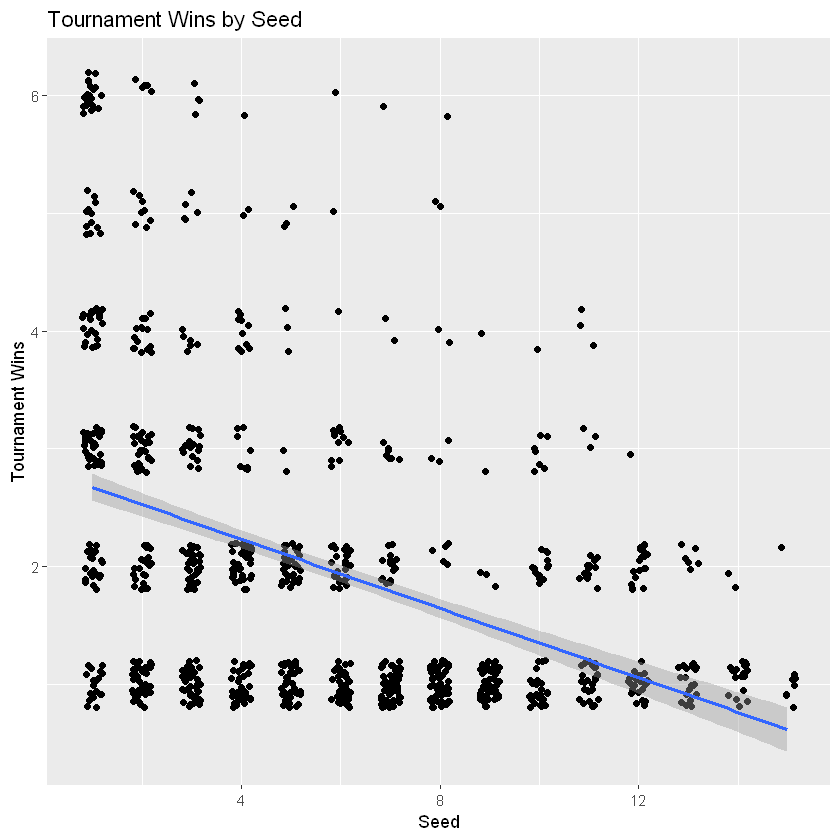

In [22]:
seeds[, .(Season, WTeamID = TeamID, seed_num = as.numeric(substr(Seed, 2, 3)))
      ][wins_t, on = c('Season', 'WTeamID')] %>%
    ggplot(aes(x = seed_num, y = tW)) + 
    geom_jitter(width = 0.2, height = 0.2) + 
    geom_smooth(method = 'lm') + 
    labs(
        x = 'Seed', 
        y = 'Tournament Wins', 
        title = 'Tournament Wins by Seed')

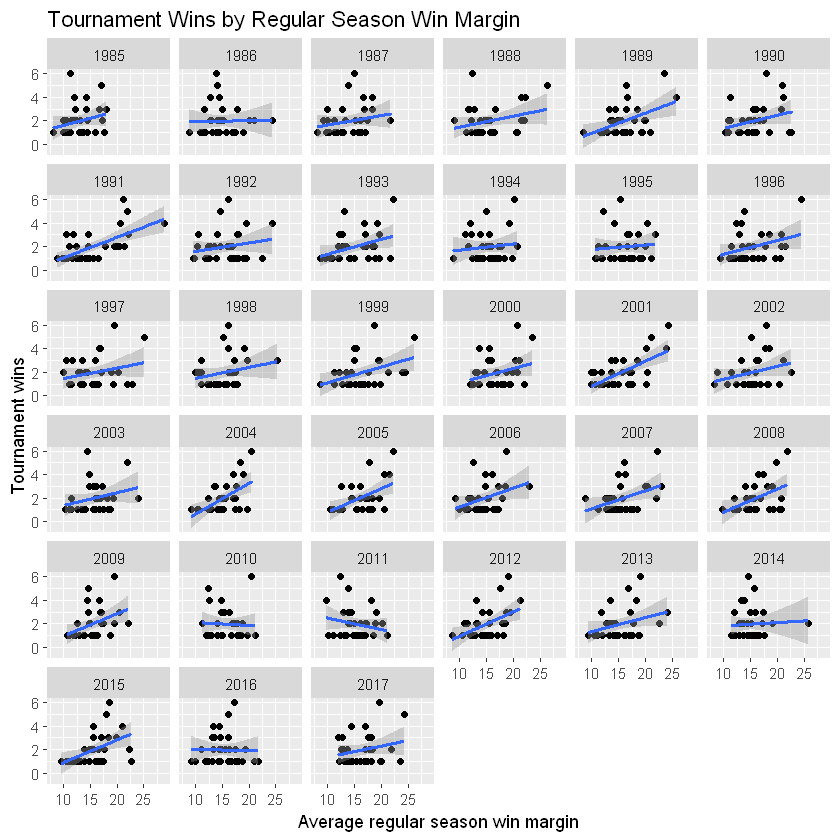

In [24]:
seas_results[, .(avg_win_marg = mean(WScore - LScore)), by = c('WTeamID', 'Season')
             ][wins_t, on = c('WTeamID', 'Season')] %>%
    ggplot(aes(x = avg_win_marg, y = tW)) + 
    geom_point() + 
    geom_smooth(method = 'lm') +
    labs(
        x = 'Average regular season win margin', 
        y = 'Tournament wins', 
        title = 'Tournament Wins by Regular Season Win Margin') + 
    facet_wrap(~Season) 

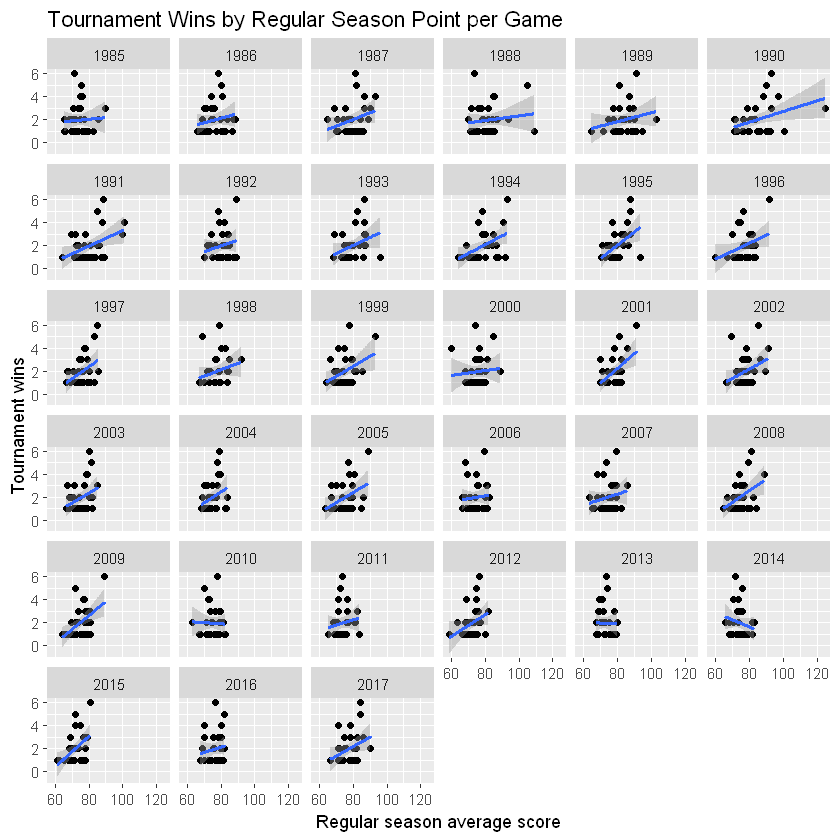

In [31]:
wins <- seas_results[, .(n_games = .N, sum_score = sum(WScore)), by = c('WTeamID', 'Season')]

losses <- seas_results[, .(n_games = .N, sum_score = sum(LScore)), by = c('LTeamID', 'Season')]

all_games <- rbindlist(list(wins, losses))

all_games <- all_games[, .(rs_ppg = sum(sum_score) / sum(n_games)), by = c('WTeamID', 'Season')]

all_games[wins_t, on = c('WTeamID', 'Season')] %>%
    ggplot(aes(x = rs_ppg, y = tW)) + 
    geom_point() + 
    geom_smooth(method = 'lm') + 
    facet_wrap( ~ as.factor(Season)) + 
    labs(
        x = 'Regular season average score', 
        y = 'Tournament wins', 
        title = 'Tournament Wins by Regular Season Point per Game')

In [25]:
stats_season <- stats_all[, .(
    FGP = sum(FGM) / sum(FGA),
    FGP3 = sum(FGM3) / sum(FGA3),
    FTP = sum(FTM) / sum(FTA),
    ORPG = mean(OR),
    DRPG = mean(DR),
    ASPG = mean(AST),
    TOPG = mean(TO),
    STPG = mean(STL),
    BLPG = mean(BLK),
    PFPG = mean(PF),
    MORP = mean(ORP),
    MPOS = mean(POS))
    , by = c('TeamID', 'Season')]

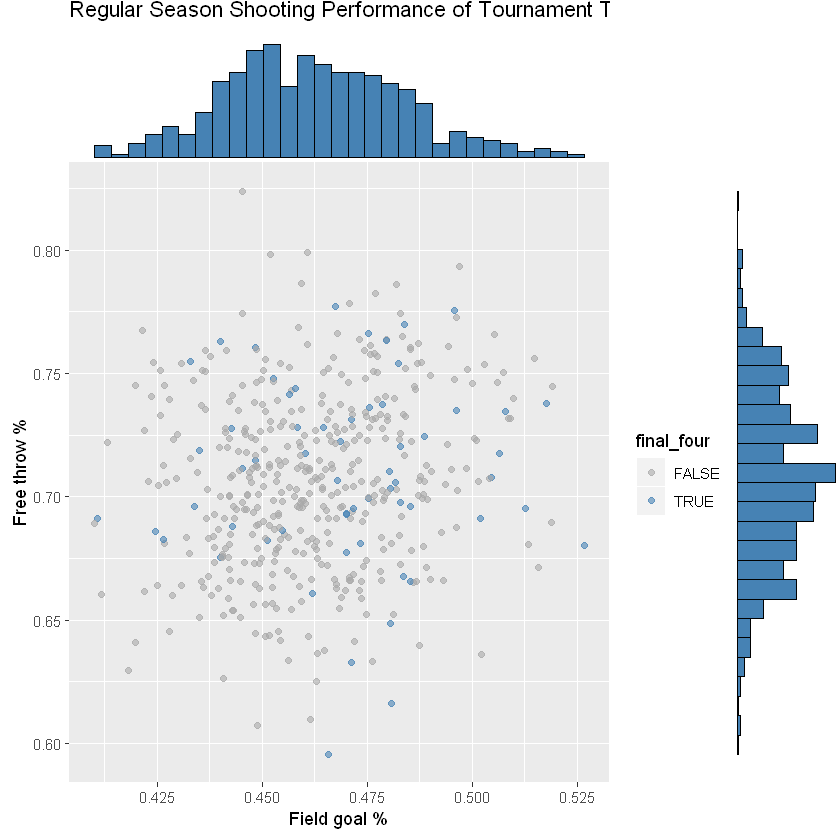

In [26]:
g1 <- stats_season[wins_t, on = c(TeamID = 'WTeamID', 'Season'), nomatch = 0
              ][, final_four := tW >= 4] %>%
    ggplot(aes(x = FGP, y = FTP, color = final_four)) + 
    geom_point(alpha = 0.6) +
    labs(
        x = 'Field goal %', 
        y = 'Free throw %', 
        title = 'Regular Season Shooting Performance of Tournament Teams') +
    scale_color_manual(values = c('darkgrey', 'steelblue'))

ggMarginal(g1, type = 'histogram', fill = 'steelblue')

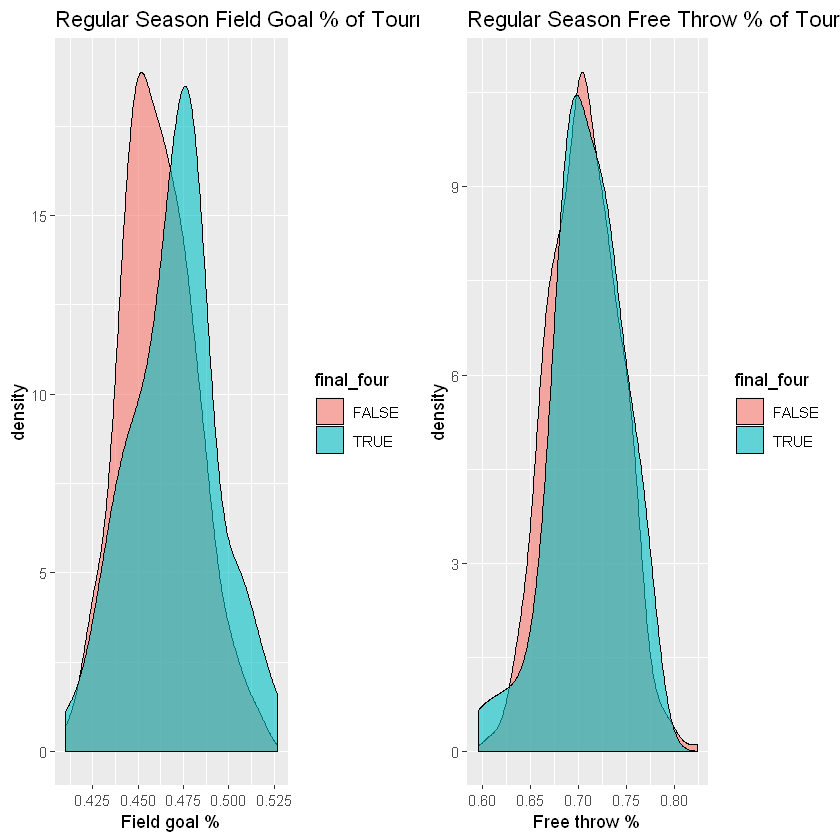

In [29]:
g1 <- stats_season[wins_t, on = c(TeamID = 'WTeamID', 'Season'), nomatch = 0
              ][, final_four := tW >= 4] %>%
    ggplot(aes(x = FGP, fill = final_four)) + 
    geom_density(alpha = 0.6) + 
    labs(x = 'Field goal %', title = 'Regular Season Field Goal % of Tournament Teams')

g2 <- stats_season[wins_t, on = c(TeamID = 'WTeamID', 'Season'), nomatch = 0
              ][, final_four := tW >= 4] %>%
    ggplot(aes(x = FTP, fill = final_four)) + 
    geom_density(alpha = 0.6) + 
    labs(x = 'Free throw %', title = 'Regular Season Free Throw % of Tournament Teams')

grid.arrange(g1, g2, ncol = 2)

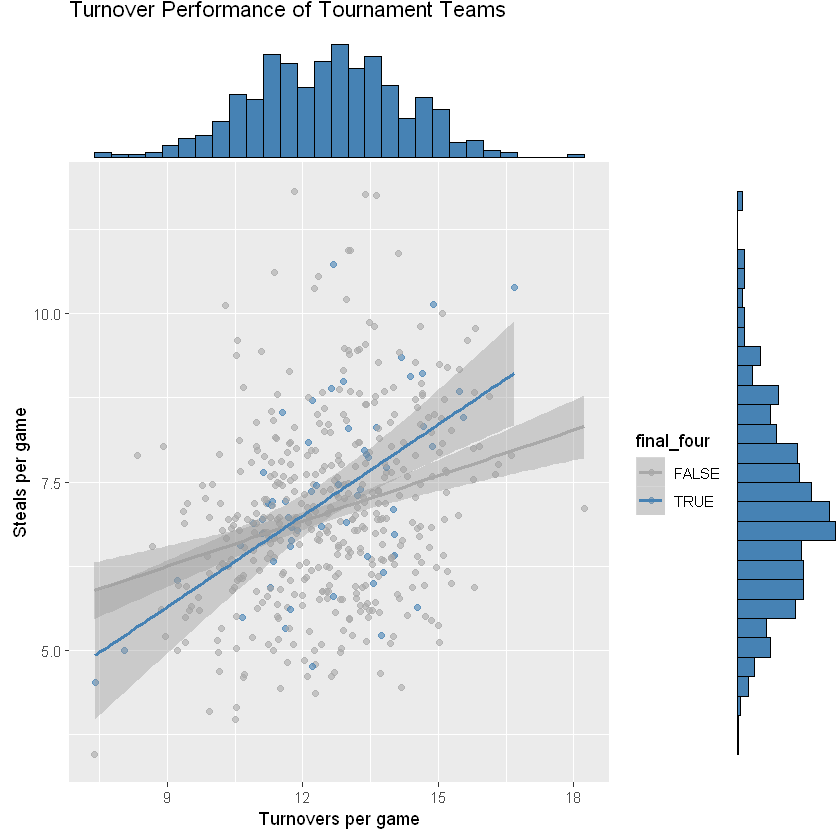

In [30]:
g1 <- stats_season[wins_t, on = c(TeamID = 'WTeamID', 'Season'), nomatch = 0
              ][, final_four := tW >= 4] %>%
    ggplot(aes(x = TOPG, y = STPG, color = final_four)) + 
    geom_point(alpha = 0.6) +
    geom_smooth(aes(color = final_four), method = 'lm') +
    labs(
        x = 'Turnovers per game', 
        y = 'Steals per game', 
        title = 'Turnover Performance of Tournament Teams') +
    scale_color_manual(values = c('darkgrey', 'steelblue')) 

ggMarginal(g1, type = 'histogram', fill = 'steelblue')

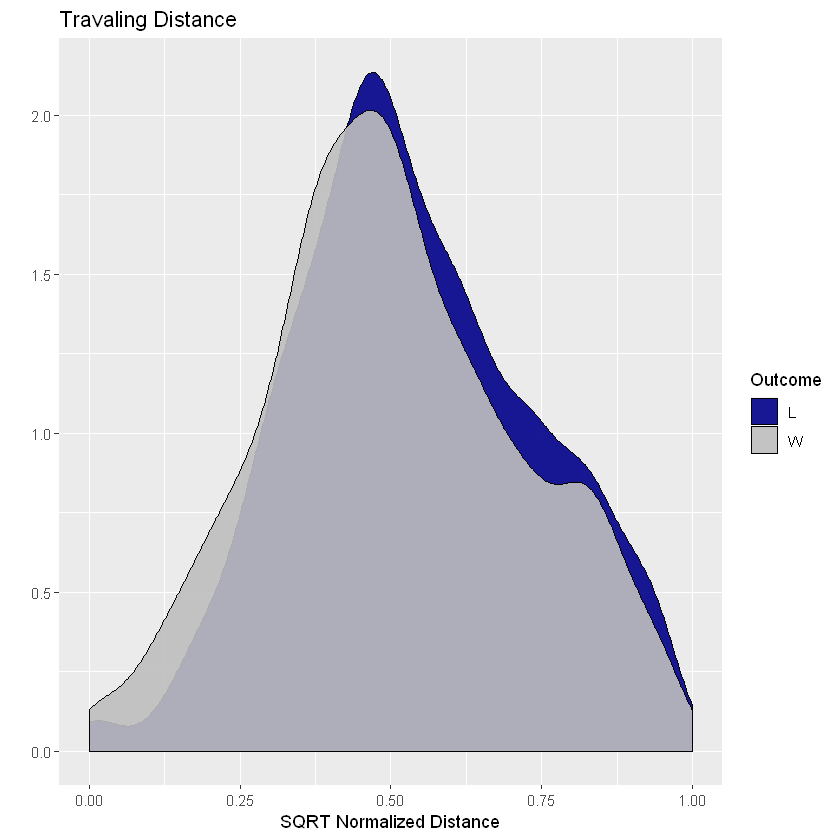

In [54]:
D1 <- distance %>%
    ggplot(aes(x =sqrt_distance, fill = Outcome)) +
    geom_density(alpha = 0.9) +
    scale_fill_manual(values = c('darkblue', 'grey')) + 
    labs(x = 'SQRT Normalized Distance', y = '', title = 'Travaling Distance')
D1